In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
import numpy as np

import cv2
import imageio

import matplotlib.pyplot as plt
from tqdm import tqdm

from transformer import ParticleTransformer

## Load data

In [2]:
# Load data
Frames = 512
dt = 0.1
n = 512

# Load different timelines
n_timelines = 100

raw_inputs = []
raw_outputs = []

for i in tqdm(range(n_timelines)):
    timeline = torch.load(f"../data-gen/data/n_{n}_dt_{dt}_F_{Frames}/cloud/{i:06}.pt", weights_only=True)
    G = timeline["G"]
    X, V, m = timeline["X"], timeline["V"], torch.broadcast_to(timeline["m"][None,:,None], (Frames, n, 1))
    features = torch.concat((X, V, m), dim=2)
    raw_inputs.append(features[:-1])
    raw_outputs.append(features[1:])

raw_inputs = torch.concat(raw_inputs, dim=0)
raw_outputs = torch.concat(raw_outputs, dim=0)
assert raw_inputs.shape == raw_outputs.shape
print(f"Raw inputs shape: {raw_inputs.shape} ({raw_inputs.nbytes / (1024**3):.3f} GB)")

print(f"Loaded {len(raw_inputs)} examples")

100%|██████████| 100/100 [00:00<00:00, 194.38it/s]


Raw inputs shape: torch.Size([51100, 512, 5]) (0.487 GB)
Loaded 51100 examples


## Train model

In [3]:
model = ParticleTransformer(input_dim=5,
                            latent_dim=64,
                            hidden_dim=64,
                            embedding_layers=2,
                            transformer_layers=4,
                            n_heads=8,
                            ff_dim=512,             # Feed-forward dimension in transformer
                            output_dim=4,           # Output dimension (same as input_dim in this case)
                            dropout=0.1             # Dropout rate
).cpu()
summary(model, input_size=(2, 512, 5))

Layer (type:depth-idx)                        Output Shape              Param #
ParticleTransformer                           [2, 512, 4]               --
├─Sequential: 1-1                             [1024, 64]                --
│    └─Linear: 2-1                            [1024, 64]                384
│    └─ReLU: 2-2                              [1024, 64]                --
│    └─Dropout: 2-3                           [1024, 64]                --
│    └─Linear: 2-4                            [1024, 64]                4,160
│    └─ReLU: 2-5                              [1024, 64]                --
│    └─Dropout: 2-6                           [1024, 64]                --
├─TransformerEncoder: 1-2                     [2, 512, 64]              --
│    └─ModuleList: 2-7                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [2, 512, 64]              83,008
│    │    └─TransformerEncoderLayer: 3-2      [2, 512, 64]              83,008
│    │  

In [14]:
# Define batch size
batch_size = 64

dataset = TensorDataset(raw_inputs.cuda(), raw_outputs.cuda())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fun = torch.nn.MSELoss()

In [ ]:
epochs = 2
loss_history = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")
    for inputs, targets in pbar:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fun(outputs, targets[:,:,:-1])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        loss_history.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # Compute and display the average loss for the epoch
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Text(0.5, 1.0, 'Transformer training loss')

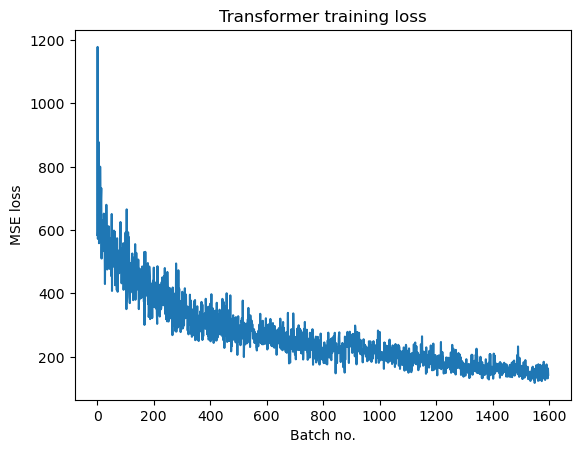

In [119]:
plt.plot(loss_history)
plt.xlabel("Batch no.")
plt.ylabel("MSE loss")
plt.title("Transformer training loss")

## Evaluate model

torch.Size([1, 512, 5])
loss: 92.80311584472656


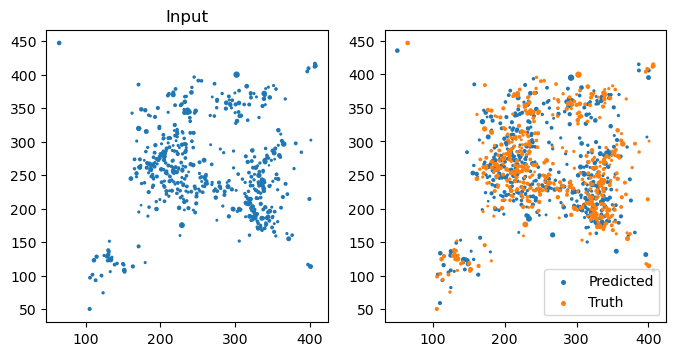

In [56]:
idx = 210

x = raw_inputs[idx:idx+1].cuda()
out = model(x)
loss = loss_fun(out, x[...,:-1])

v_mag = 4

print(x.shape)
m = x[0,:,-1].cpu()

fig, axs = plt.subplots(1, 2, figsize=(8, 3.8))
axs[0].scatter(*raw_inputs[idx][:,:2].T.cpu(), s=m)
axs[0].set_title("Input")
axs[1].scatter(*out[0][:,:2].T.cpu().detach().numpy(), s=m, label="Predicted")
axs[1].scatter(*raw_outputs[idx][:,:2].T.cpu(), s=m, label="Truth")
axs[1].legend()

print(f"loss: {loss}")

## Generate example video

In [121]:
idx = 0

x = raw_inputs[idx:idx+1,:,:-1].cuda()
m = raw_inputs[idx:idx+1,:,-1:].cuda()
m_cpu = torch.sqrt(m.squeeze()).cpu()

rendered_frames = []
fig, ax = plt.subplots(figsize=(5.12, 5.12), dpi=100)

with torch.no_grad():
    for i in tqdm(range(90), ncols=80):
        ax.clear()
        ax.set_xlim(0, 512)
        ax.set_ylim(0, 512)
        ax.scatter(*x[0][:,:2].T.cpu().detach().numpy(), s=m_cpu, c="white")
        fig.patch.set_facecolor('black')
        plt.axis("off")
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
        image = image.reshape(fig.canvas.get_width_height() + (4,))
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        
        # Make the image writable by creating a copy
        image = image.copy()
        rendered_frames.append(image)

        x = model(torch.concat((x, m), dim=2))

plt.close()

print(f"Finished rendering, saving to MP4...")
imageio.mimsave(f"./transformer_render.mp4", rendered_frames, fps=30)  

100%|███████████████████████████████████████████| 90/90 [00:02<00:00, 37.60it/s]


Finished rendering, saving to MP4...
